In [1]:
!pip install torchtext==0.11.2
#!pip install torchdata==0.3.0
#!pip install torch
#!pip install spellchecker
#!pip install pyspellchecker
#!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torchtext
import torch
import pandas as pd
import numpy as np
import nltk
import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# From https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

# df_clean = pd.read_csv("sample_data_clean.csv")
df_clean = pd.read_csv("train_clean.csv")
df_clean['label'] =  (df_clean[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]\
                     .sum(axis=1) > 0).astype(int)
df_clean.rename(columns={'toxic_any': 'label', 'cleaned_text': 'clean_text'}, inplace=True)
# df_clean = df_clean[['label', 'clean_text']]
df_clean = df_clean[['label', 'clean_text']]
df_clean = df_clean.loc[df_clean.clean_text.str.len() > 15]

df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=23)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=23)
df_train.reset_index(inplace=True)
df_valid.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train.drop(columns=['index'], inplace=True)
df_valid.drop(columns=['index'], inplace=True)
df_test.drop(columns=['index'], inplace=True)

df_train.to_csv('train.csv', index=False)
df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [4]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('clean_text', text_field)]
# device = None
device = torch.device('cuda')

train, valid, test = TabularDataset.splits(path = './',
                                    train='train.csv', 
                                    validation='valid.csv',
                                    test='test.csv',
                                    format='CSV',
                                    fields=fields, 
                                    skip_header=True)

In [5]:
# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)

In [74]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.7)

        self.fc1 = nn.Linear(2*dimension, dimension)
        self.fc2 = nn.Linear(dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        # print('text_emb', text_emb.shape)
        
        packed_input = pack_padded_sequence(text_emb, text_len.to('cpu'), batch_first=True, enforce_sorted=False)
        # print('packed input', packed_input[0].shape, packed_input[1].shape)

        packed_output, _ = self.lstm(packed_input)
        # print('packed output', packed_output[0].shape, packed_output[1].shape)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # print('output', output.shape)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        # print('out_forward dim', out_forward.shape)
        out_reverse = output[:, 0, self.dimension:]
        # print('out_reverse dim', out_reverse.shape)

        out_reduced = torch.cat((out_forward, out_reverse), 1)
        # print('out_reduced', out_reduced.shape)
        text_fea = self.drop(out_reduced)
        # print('text_fea', text_fea.shape)

        text_fea = self.fc1(text_fea)
        text_fea = self.fc2(text_fea)
        # print('text_fea2', text_fea.shape)
        text_fea = torch.squeeze(text_fea, 1)
        # print('text_fea2', text_fea.shape)
        text_out = torch.sigmoid(text_fea)
        # print('text_out', text_out.shape)

        return text_out

In [75]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [77]:
import torch.optim as optim

device = torch.device('cuda')

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    # training loop
    model.train()
    for epoch in range(num_epochs):
      #[('toxic_any', label_field), ('comment_text', text_field)]
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

hidden_dims = 60
lr = 0.0005
model = LSTM(dimension=hidden_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [1487/29740], Train Loss: 0.1976, Valid Loss: 0.1421
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/10], Step [2974/29740], Train Loss: 0.1133, Valid Loss: 0.1480


KeyboardInterrupt: ignored

Model loaded from <== metrics.pt


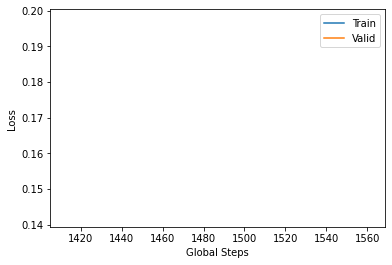

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

train_loss_list, valid_loss_list, global_steps_list = load_metrics('metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== model.pt


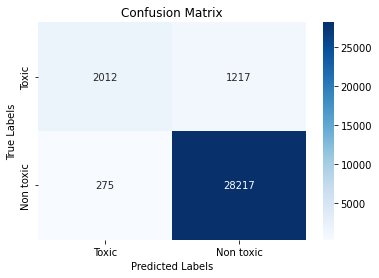

In [79]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:    

            text = text.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    #print('Classification Report:')
    # print(y_true)
    # print(y_pred)
    #print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Toxic', 'Non toxic'])
    ax.yaxis.set_ticklabels(['Toxic', 'Non toxic'])
    
best_model = LSTM(dimension=hidden_dims).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=lr)

load_checkpoint('model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [80]:
def predict_toxic(model, data, threshold=0.5):

    pred_df = pd.DataFrame(data, columns=["label", "clean_text"])
    pred_df["clean_text"] = pred_df["clean_text"].apply(preprocessing.clean_text)
    pred_df.to_csv("predict.csv", index=False)
    
    valid, predict = TabularDataset.splits(path = './',
                                    validation='test.csv',
                                    test='predict.csv',
                                    format='CSV',
                                    fields=fields, 
                                    skip_header=True)
    predict_iter = BucketIterator(predict, batch_size=1, sort_key=lambda x: len(x.clean_text),
                            device=device, sort=True, sort_within_batch=True)

    df_list = []
    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in predict_iter:    
            output = model(text, text_len)
            df_list.append([" ".join([text_field.vocab.itos[i.item()] for i in text[0]]), output.item()])

    df = pd.DataFrame(df_list, columns=["text", "probability_toxic"])

    return df

In [81]:
data = [
        [0, "Hey you smell nice. how is the weather today"],
        [1, "They are liberal i.diots who are un.educated"],
        [1, "Anyone who voted for Trump is a mo.ron"],
        [0, "This is a normal comment."]
]

In [82]:
pred_df = predict_toxic(best_model, data)

In [83]:
pred_df

,text,probability_toxic
0,this is a normal comment,0.419263
1,they are liberal idiots who are uneducated,0.996397
2,anyone who voted for trump is a moron,0.993159
3,hey you smell nice how is the weather today,0.771417


In [ ]:
# TODO: add more positive cases?
# TODO: mess with parameters, optimizers, activations functions, etc
# TODO: add another variable: how many bad words found from words database